# Analising Video with YOLO and MLRun


In this notebook we are going to analise the objects from a video file using the following process:

### Split and Upload Files to Minio


In [1]:
%pip install opencv-python


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from video_spliter import Video_Spliter

In [3]:
secrets = {"MINIO_URL": "", "MINIO_AK": "", "MINIO_SK": ""}

In [4]:
v = Video_Spliter()

In [5]:
v.split_video('mov_bbb.mp4', 'data')

### Upload Data to Minio


In [6]:
%pip install minio


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import minio
client = minio.Minio(secrets["MINIO_URL"], access_key=secrets["MINIO_AK"], secret_key=secrets["MINIO_SK"])

In [8]:
import os

def upload_local_directory_to_minio(client, local_path, bucket_name, minio_path):
  """Uploads a local directory to a Minio bucket.

  Args:
    local_path: The path to the local directory.
    bucket_name: The name of the Minio bucket.
    minio_path: The path to the directory in the Minio bucket.
  """

  assert os.path.isdir(local_path)
  for root, dirs, files in os.walk(local_path):
    for file in files:
      remote_path = os.path.join(minio_path, os.path.relpath(os.path.join(root, file), local_path))
      remote_path = remote_path.replace(os.sep, '/')

      # Upload the file.
      client.fput_object(bucket_name, remote_path, os.path.join(root, file))

upload_local_directory_to_minio(client, 'data/mov_bbb.mp4/', 'video', 'mov_bbb.mp4')


List objects in the frame order

In [9]:
objects = client.list_objects(
    "video", recursive=True, prefix="mov_bbb.mp4/frames/"
)
file_names = [obj.object_name for obj in objects]
file_names = sorted(file_names, key=lambda string: string.lower())
file_names[-1]


'mov_bbb.mp4/frames/frame_00000249.jpg'

### Create MLRun Model Serving

Create the custom server class: serving.py 

```python
from typing import List
import mlrun
import torch
import minio
from PIL import Image


class ClassifierModel(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        print("aa")
        torch.hub.set_dir('.')
        self.model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
        self.minio_client = minio.Minio('my-docker-ip:9000', access_key='', secret_key='', secure=False)

    def dowload_files(self, bucket: str, path_list: list):
        images = []
        for path in path_list:
            try:
                # dowload image
                self.minio_client.fget_object(bucket, path, "test.jpg")
                im = Image.open('test.jpg')
                images.append(im)
            except Exception as e:
                print(e)
                continue
        
        return images

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        images = self.dowload_files(str(body["bucket"]), body['inputs'])
        result = self.model(images)
        return str(result.tolist())
```

In [10]:
%pip install mlrun


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
import mlrun

project = mlrun.get_or_create_project('yolo', context="./", user_project=True)

> 2023-10-04 11:50:26,723 [info] Server and client versions are not the same but compatible: {'parsed_server_version': VersionInfo(major=1, minor=4, patch=0, prerelease=None, build=None), 'parsed_client_version': VersionInfo(major=1, minor=3, patch=0, prerelease=None, build=None)}
> 2023-10-04 11:50:26,744 [info] loaded project yolo from MLRun DB


In [12]:
project.set_secrets(secrets=secrets, provider="kubernetes")

In [13]:
object_tracker = mlrun.code_to_function('object_tracker', filename='image_tracking.py', kind='serving',image='mlrun/ml-models')

In [14]:
# define resources
object_tracker.spec.replicas = 1
object_tracker.with_limits(mem="3G", cpu=2)

In [15]:
object_tracker.spec.build.commands = [
    "apt-get update && apt-get install -y cmake gcc g++ libglu1-mesa-dev",
    "python -m pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt",
    "python -m pip install minio"
]

In [16]:
object_tracker.add_model('Pytorch',model_path=  ' ', class_name='TrackingModel')

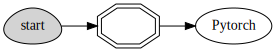

In [17]:
object_tracker.spec.graph.plot(rankdir="LR")    

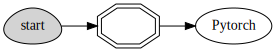

In [18]:
# create object detector
object_detector = mlrun.code_to_function('object_detector', filename='image_objects.py', kind='serving',image='mlrun/ml-models')
# define resources
object_detector.spec.replicas = 1
object_detector.with_limits(mem="3G", cpu=2)
object_detector.spec.build.commands = [
    "apt-get update && apt-get install -y cmake gcc g++ libglu1-mesa-dev",
    "python -m pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt",
    "python -m pip install minio"
]
object_detector.add_model('Pytorch',model_path=  ' ', class_name='ObjectDetector')
object_detector.spec.graph.plot(rankdir="LR")    

Install dependencies to local testing

### Deploy Model Server on Nucleo and test

In [19]:
import time

project.deploy_function(object_tracker)
# wait 30s after the deployment to the server statup 
time.sleep(30)

> 2023-10-04 11:50:26,865 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-10-04 11:50:26,868 [info] Starting remote function deploy
2023-10-04 11:50:26  (info) Deploying function
2023-10-04 11:50:26  (info) Building
2023-10-04 11:50:26  (info) Staging files and preparing base images
2023-10-04 11:50:26  (info) Building processor image
2023-10-04 11:52:02  (info) Build complete
2023-10-04 11:52:10  (info) Function deploy complete
> 2023-10-04 11:52:17,398 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-yolo-test-object-tracker.digitalhub-test.svc.cluster.local:8080'], 'external_invocation_urls': [':31780']}


In [20]:
import time

project.deploy_function(object_detector)
# wait 30s after the deployment to the server statup 
time.sleep(30)

> 2023-10-04 11:52:47,470 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-10-04 11:52:47,472 [info] Starting remote function deploy
2023-10-04 11:52:47  (info) Deploying function
2023-10-04 11:52:47  (info) Building
2023-10-04 11:52:47  (info) Staging files and preparing base images
2023-10-04 11:52:47  (info) Building processor image
2023-10-04 11:54:52  (info) Build complete
2023-10-04 11:55:02  (info) Function deploy complete
> 2023-10-04 11:55:08,058 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-yolo-test-object-detector.digitalhub-test.svc.cluster.local:8080'], 'external_invocation_urls': [':32736']}


In [21]:
sample = {"inputs": file_names, "bucket": "video"}
result = object_detector.invoke(path=f"/v2/models/Pytorch/infer", body=sample)

> 2023-10-04 11:55:38,123 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-yolo-test-object-detector.digitalhub-test.svc.cluster.local:8080/v2/models/Pytorch/infer'}


In [22]:
sample = {"inputs": file_names, "bucket": "video"}
result = object_tracker.invoke(path=f"/v2/models/Pytorch/infer", body=sample)

> 2023-10-04 11:56:07,552 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-yolo-test-object-tracker.digitalhub-test.svc.cluster.local:8080/v2/models/Pytorch/infer'}


### Remake video

The OpenCV version from pip only supports the mp4v codec due to license issues. To support other codecs, you can install OpenCV from the conda-forge channel.

```conda install -c conda-forge opencv```

or via apt:

```apt-get install python3-opencv```

In [23]:
v.frames_to_video("data/mov_bbb.mp4/", True)